In [1]:
import numpy as np
import matplotlib.pyplot as plt
import galsim

In [2]:
theta_E = 0.84/2            # unit: arcsec
deltaPix = 0.2
fwhm = 0.7
num_pix = 30

In [3]:
from lenstronomy.LensModel.lens_model import LensModel
lens_model = LensModel(lens_model_list=['POINT_MASS'])                      # point mass lens
kwargs_lens = [{'theta_E': theta_E, 'center_x': 0, 'center_y': 0}]

In [4]:
from lenstronomy.Data.psf import PSF
kwargs_psf = {'psf_type': 'GAUSSIAN',  # type of PSF model (supports 'GAUSSIAN' and 'PIXEL')
              'fwhm': fwhm,  # full width at half maximum of the Gaussian PSF (in angular units)
              'pixel_size': deltaPix  # angular scale of a pixel (required for a Gaussian PSF to translate the FWHM into a pixel scale)
             }
psf = PSF(**kwargs_psf)


In [5]:
from lenstronomy.Util.util import make_grid, array2image

In [6]:
from lenstronomy.Data.pixel_grid import PixelGrid

# setup the keyword arguments to create the Data() class #
x0 = make_grid(num_pix, deltaPix)[0][0]
ra_at_xy_0 = dec_at_xy_0 = x0 # coordinate in angles (RA/DEC) at the position of the pixel edge (0,0)
print('ra, dec range: [-{0}, {0}]'.format(-x0))
transform_pix2angle = np.array([[1, 0], [0, 1]]) * deltaPix  # linear translation matrix of a shift in pixel in a shift in coordinates
kwargs_pixel = {'nx': num_pix, 'ny': num_pix,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle}

pixel_grid = PixelGrid(**kwargs_pixel)

ra, dec range: [-2.9000000000000004, 2.9000000000000004]


In [8]:
from lenstronomy.PointSource.point_source import PointSource

# unlensed source positon #
point_source_model_list = ['SOURCE_POSITION']
pointSource = PointSource(point_source_type_list=point_source_model_list, lens_model=lens_model, fixed_magnification_list=[True])
kwargs_ps = [{'ra_source': 0, 'dec_source': 0, 'source_amp': 100}]

In [9]:
from lenstronomy.ImSim.image_model import ImageModel
# define the numerics #
supersampling_factor = 5
kwargs_numerics = {'supersampling_factor': supersampling_factor, # super sampling factor of (partial) high resolution ray-tracing
                        'compute_mode': 'regular', # 'regular' or 'adaptive'
                        'supersampling_convolution': True,  # bool, if True, performs the supersampled convolution (either on regular or adaptive grid)
                        'supersampling_kernel_size': None,  # size of the higher resolution kernel region (can be smaller than the original kernel). None leads to use the full size
                        'flux_evaluate_indexes': None,  # bool mask, if None, it will evaluate all (sub) pixels
                        'supersampled_indexes': None,  # bool mask of pixels to be computed in supersampled grid (only for adaptive mode)
                        'compute_indexes': None,  # bool mask of pixels to be computed the PSF response (flux being added to). Only used for adaptive mode and can be set =likelihood mask.
                        'point_source_supersampling_factor': 3,  # int, supersampling factor when rendering a point source (not used in this script)
                       }

NameError: name 'pointSource' is not defined

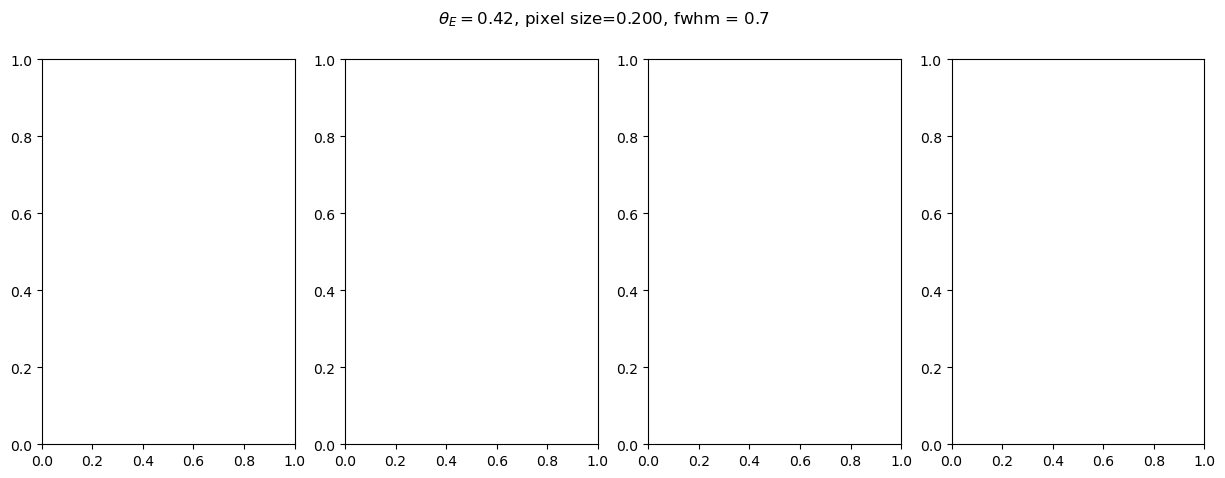

In [10]:
# POINT SOURCE
fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharex=False, sharey=False)
x = [0, 0.02, 0.05]
fig.suptitle(f'$\\theta_E={theta_E}$, pixel size={deltaPix:.3f}, fwhm = {fwhm}')

imageModel = ImageModel(data_class=pixel_grid, psf_class=psf, lens_model_class=LensModel(lens_model_list=['POINT_MASS']),
                        # source_model_class=lightModel_source,
                        # lens_light_model_class=lightModel_lens,
                        point_source_class=pointSource,
                        kwargs_numerics=kwargs_numerics)
image = imageModel.image(kwargs_ps=kwargs_ps, kwargs_lens = [{'theta_E': 0}], unconvolved=True)

i = 3
axes[i].imshow(image, origin='lower')
    # axes[i].matshow(image)
axes[i].set_xticks([])
axes[i].set_yticks([])

axes[i].set_xlabel('ra')
axes[i].set_ylabel('dec')
axes[i].set_title(f'UnLensed')

imageModel = ImageModel(data_class=pixel_grid, psf_class=psf, lens_model_class=lens_model,
                        # source_model_class=lightModel_source,
                        # lens_light_model_class=lightModel_lens,
                        point_source_class=pointSource, 
                        kwargs_numerics=kwargs_numerics)
for i in range(3):
    image = imageModel.image(kwargs_lens = [{'theta_E': theta_E, 'center_x': x[i], 'center_y': 0}],
                            # kwargs_source=kwargs_light_source,
                            kwargs_ps=kwargs_ps, unconvolved=True)
    # image = image[::2,::2] + image[1::2,::2] + image[1::2,1::2] + image[::2,1::2]
    axes[i].matshow(image, origin='lower')
    axes[i].set_xticks([])
    axes[i].set_yticks([])

    axes[i].set_xlabel('ra')
    axes[i].set_ylabel('dec')
    axes[i].set_title(f'$\\beta={x[i]}$')
fig.tight_layout()

In [11]:
# use gaussian to substitute point source
from lenstronomy.LightModel.light_model import LightModel
lightModel_source = LightModel(light_model_list=['GAUSSIAN'])
kwargs_light = [{'amp': 100, 'center_x': 0, 'center_y': 0, 'sigma': fwhm/100}]

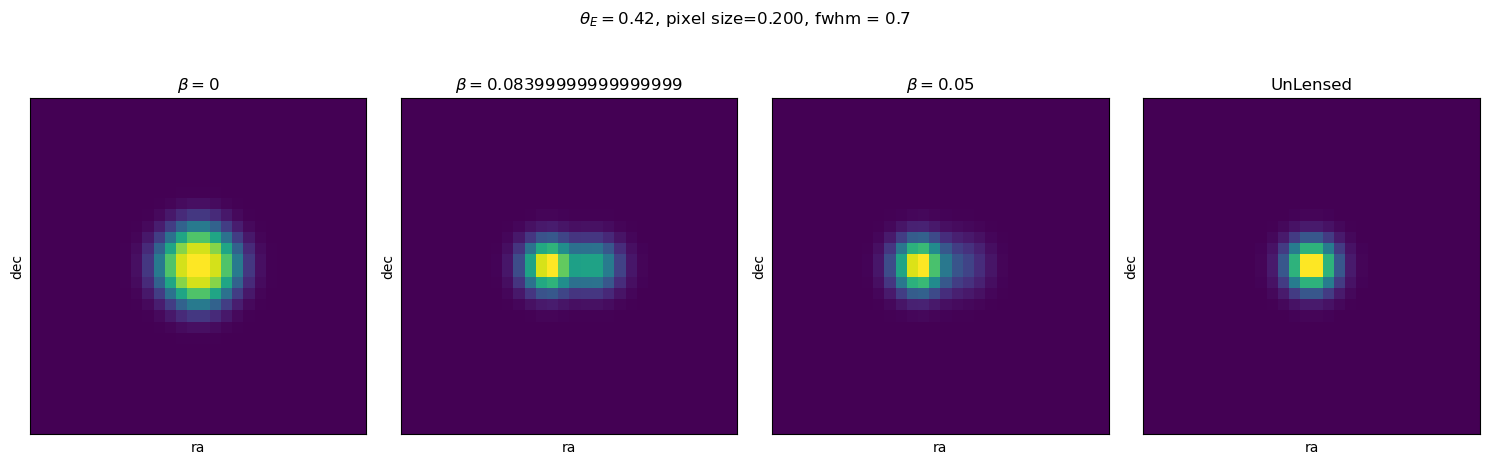

In [12]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharex=False, sharey=False)
x = [0, theta_E/5, 0.05]
fig.suptitle(f'$\\theta_E={theta_E}$, pixel size={deltaPix:.3f}, fwhm = {fwhm}')

imageModel = ImageModel(data_class=pixel_grid, psf_class=psf, lens_model_class=lens_model,
                        source_model_class=lightModel_source,
                        point_source_class=None,
                        kwargs_numerics=kwargs_numerics)


image = imageModel.image(kwargs_lens = [{'theta_E': 0}], kwargs_source=kwargs_light)

i = 3
axes[i].imshow(image, origin='lower')
    # axes[i].matshow(image)
axes[i].set_xticks([])
axes[i].set_yticks([])

axes[i].set_xlabel('ra')
axes[i].set_ylabel('dec')
axes[i].set_title(f'UnLensed')

for i in range(3):
    image = imageModel.image(kwargs_lens = [{'theta_E': theta_E, 'center_x': x[i], 'center_y': 0}],
                            kwargs_source=kwargs_light)
    res = galsim.hsm.FindAdaptiveMom(galsim.Image(image))
    # print('e =', res.observed_shape.e)
    axes[i].matshow(image, origin='lower')
    axes[i].set_xticks([])
    axes[i].set_yticks([])

    axes[i].set_xlabel('ra')
    axes[i].set_ylabel('dec')
    axes[i].set_title(f'$\\beta={x[i]}$')
fig.tight_layout()

ra, dec range: [-2.99, 2.99]


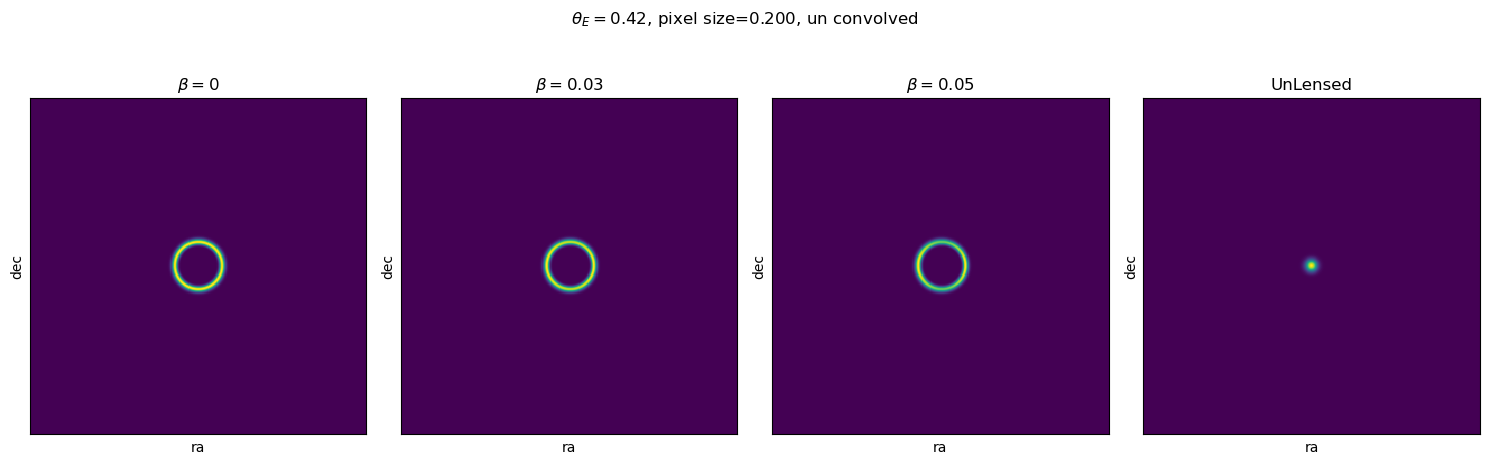

In [13]:
deltaPix2 = deltaPix/10
num_pix2 = num_pix*10
x0 = make_grid(num_pix2, deltaPix2)[0][0]
ra_at_xy_0 = dec_at_xy_0 = x0 # coordinate in angles (RA/DEC) at the position of the pixel edge (0,0)
print('ra, dec range: [-{0}, {0}]'.format(-x0))
transform_pix2angle = np.array([[1, 0], [0, 1]]) * deltaPix2  # linear translation matrix of a shift in pixel in a shift in coordinates
kwargs_pixel = {'nx': num_pix2, 'ny': num_pix2,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle}

pixel_grid2 = PixelGrid(**kwargs_pixel)

ligth = LightModel(light_model_list=['GAUSSIAN'])                               # use gaussian to substitute point source
kwargs_light = [{'amp': 50, 'center_x': 0, 'center_y': 0, 'sigma': fwhm/10}]

fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharex=False, sharey=False)
x = [0, 0.03, 0.05]
fig.suptitle(f'$\\theta_E={theta_E}$, pixel size={deltaPix:.3f}, un convolved')

imageModel = ImageModel(data_class=pixel_grid2, psf_class=psf, lens_model_class=lens_model,
                        source_model_class=lightModel_source,
                        # lens_light_model_class=lightModel_lens,
                        point_source_class=None,
                        kwargs_numerics=kwargs_numerics)

image = imageModel.image(kwargs_lens = [{'theta_E': 0}], kwargs_source=kwargs_light, unconvolved=True)

i = 3
axes[i].imshow(image, origin='lower')
    # axes[i].matshow(image)
axes[i].set_xticks([])
axes[i].set_yticks([])

axes[i].set_xlabel('ra')
axes[i].set_ylabel('dec')
axes[i].set_title(f'UnLensed')

for i in range(3):
    image = imageModel.image(kwargs_lens = [{'theta_E': theta_E, 'center_x': x[i], 'center_y': 0}],
                            kwargs_source=kwargs_light, unconvolved=True)
    axes[i].matshow(image, origin='lower')
    axes[i].set_xticks([])
    axes[i].set_yticks([])

    axes[i].set_xlabel('ra')
    axes[i].set_ylabel('dec')
    axes[i].set_title(f'$\\beta={x[i]}$')
fig.tight_layout()


e = 7.714718012707254e-15
e = 0.0077189174480736256
e = 0.047626428306102746


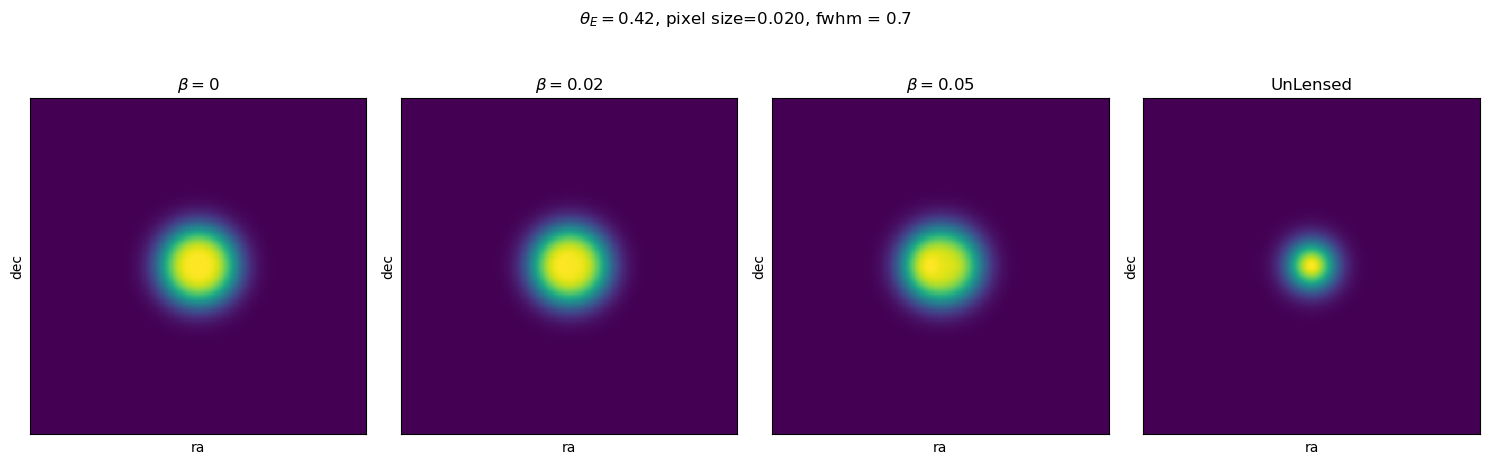

In [14]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharex=False, sharey=False)
x = [0, 0.02, 0.05]
fig.suptitle(f'$\\theta_E={theta_E}$, pixel size={deltaPix2:.3f}, fwhm = {fwhm}')

image = imageModel.image(kwargs_lens = [{'theta_E': 0}], kwargs_source=kwargs_light)
i = 3
axes[i].imshow(image, origin='lower')
    # axes[i].matshow(image)
axes[i].set_xticks([])
axes[i].set_yticks([])

axes[i].set_xlabel('ra')
axes[i].set_ylabel('dec')
axes[i].set_title(f'UnLensed')

for i in range(3):
    image = imageModel.image(kwargs_lens = [{'theta_E': theta_E, 'center_x': x[i], 'center_y': 0}],
                            kwargs_source=kwargs_light)
    res = galsim.hsm.FindAdaptiveMom(galsim.Image(image))
    print('e =', res.observed_shape.e)
    axes[i].matshow(image, origin='lower')
    axes[i].set_xticks([])
    axes[i].set_yticks([])

    axes[i].set_xlabel('ra')
    axes[i].set_ylabel('dec')
    axes[i].set_title(f'$\\beta={x[i]}$')
fig.tight_layout()

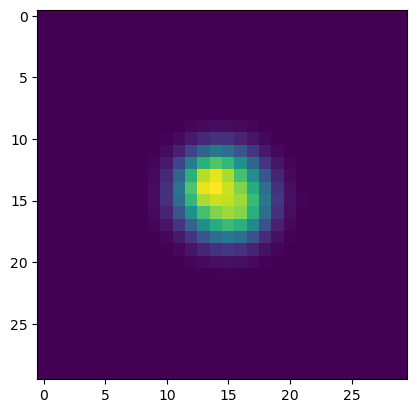

In [16]:
imageModel = ImageModel(data_class=pixel_grid, psf_class=psf, lens_model_class=lens_model,
                        source_model_class=lightModel_source,
                        # lens_light_model_class=lightModel_lens,
                        point_source_class=None,
                        kwargs_numerics=kwargs_numerics)
image = imageModel.image(kwargs_lens = [{'theta_E': theta_E, 'center_x': theta_E/(5*1.414), 'center_y': theta_E/(5*1.414)}],
                            kwargs_source=kwargs_light)
plt.imshow(image)

In [17]:
import galsim

In [18]:
res = galsim.hsm.FindAdaptiveMom(galsim.Image(image))

In [19]:
res.observed_shape.e

0.1257402002811432